## Paper Machine Sheet Break Prediction with CNN model.  Subset where x28 feature is 96.

### Reference and Licence

### Dataset: Rare Event Classification in Multivariate Time Series
 ### 2018-10-01  Chitta Ranjan, Markku Mustonen, Kamran Paynabar, Karim Pourak
### https://deeplearn.org/arxiv/48599/dataset:-rare-event-classification-in-multivariate-time-series

#### Summary
This notebook looks at using CNN to predict an upcoming process fault (paper break) in a paper machine.

The dataset is subdivided to focus on the most frequent samples set where feature x28 is eqal to 96.  samples ahead of a break are relabeled as class 1 to 5 and the break is relabelled as 6.  Other normal samples remain labelled as 0.

The EDA notbook shows noticable difference in many features depending on the categorical feature x28.

##### Results
The results are mixed with the CNN model having about a 8% false positive rate (when the train test split is 65-35), categorizing them as a warning state equivalent to a label between 1 and 5.
The model does a good job of detecting the actual break sample and a mixed job at identifying warning labels.  About half of these are classified as 0 (normal) and some are just classified as a differenct warning class.  This may be indicative of variability in samples prior to a break rather than a steady divergence from normal operation.  Also, the misclassification of normal state may be driven by class 1 to 5 samples that are not significantly different than a steady state normal condition

The objective to predict a warning several time period ahead of a break is somewhat realized.  Subsequent trials may include PCA and/or a different reduced set of features, with and without derivatives of the sample values.

This notebook does not balance the samples by reducing the number of normal samples.  Attempts at that showed overfitting and poor results on the test set, particularly with false positives.  The smaller normal sample size did not allow the model to train over the normal sample space.

Instead, I have used a modified argmax method in the prediction using a threshold probability ( from predict_proba ) for normals equal to their percentage in the dataset and a corresponding lower threshold for the warning and fault classes.

## Workflow
#### Clean data based on EDA notebook
- Remove low impact features based on Random Forest feature importance and those with interactions shifted with x22 & x28. 
- Retain features:
     x2, x3, x9-x13, x31, x41, x42, x44-x47, and x59 plus x22, x23, x35, x52, x53, x54
- Segregate data on the most frequent categorical-like feature in: x28 == 96
- drop short periods between faults - see below.
- Create two derivative with time relative to the sensor position features, dF/dt & dF/dt^2
- Scale the data
- Combine the data into time snap shots with 6 time periods and the position and derivatives stacked in each image.
    Each successive image is offset by one time slice (2 minutes) so an image overlaps part of its 5 preceeding images,
    with the exception the beginning, and immediately following a fault.
- Retain the original fault label 0/1, but relabel the fault label to 6, and the preceding 5 time slices to 1-5.
- Label each image as 0 or 1 through 6. 
- Buid a custom predict function to account for the imbalanced training & test sets.
- Split the data into train & test sets stratify on the 1-6 labels.  The split will be random rather than front end, back end.
- Train the data with a CNN model.
- Evaluate performance on the test set and plot the entire month (Train & Test) intermingled with the model prediction.

### Note; Periods without 6 samples between faults will be dropped in this attempt.  These faults are indicative of start-up issues.  This attempt will focus on a steady state running condition.  These faults may be  included in furture notebooks with missing stable sample times replaced with prior relevant samples (eg. aligned with the x28 feature conditions) 

### Assumption, deviations in the process variables and in their derivatives can indicate a future sheet break (a break in the continuous sheet of paper).  Stacking the individual time slices into an 12 minute picture of time can provide a warning or liklihood of an upcoming sheet break more reliably than an individual time slice, similar to a LSTM model with multiple prior sample imputs.  

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  classification_report

from random import random

import matplotlib.pyplot as plt

In [2]:
from keras import Sequential, regularizers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import livelossplot

Using TensorFlow backend.


In [3]:
df=pd.read_csv('processminer-rare-event-mts - data.csv')

In [4]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [5]:
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

In [6]:
df['x28'].nunique()

8

In [7]:
df['x28'].value_counts()

96     6574
82     4378
118    2646
139    1807
84     1313
112    1235
93      419
51       26
Name: x28, dtype: int64

### The features behavior varies based on the x28 value, as seen in the EDA notebook.   So for the first model focus on the majority of occurrances of x28, where it is equal to 96.

### Drop columns, retain features from feature importance.

In [8]:
df = df[df['x28']==96]

df= df.drop(df[['x1', 'x4', 'x5', 'x6', 'x7', 'x8', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x24', 'x25', 'x26', 'x27', 'x29', 'x30', 'x32', 'x33', 'x34', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x43', 'x48', 'x49','x50', 'x51', 'x55', 'x56', 'x57', 'x58', 'x60', 'x61']], axis =1)

In [9]:
df.shape

(6574, 24)

In [10]:
df = df.drop(df[['x28']], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 18397
Data columns (total 23 columns):
time    6574 non-null datetime64[ns]
y       6574 non-null int64
x2      6574 non-null float64
x3      6574 non-null float64
x9      6574 non-null float64
x10     6574 non-null float64
x11     6574 non-null float64
x12     6574 non-null float64
x13     6574 non-null float64
x22     6574 non-null float64
x23     6574 non-null float64
x31     6574 non-null float64
x35     6574 non-null float64
x41     6574 non-null float64
x42     6574 non-null float64
x44     6574 non-null float64
x45     6574 non-null float64
x46     6574 non-null float64
x47     6574 non-null float64
x52     6574 non-null float64
x53     6574 non-null float64
x54     6574 non-null float64
x59     6574 non-null float64
dtypes: datetime64[ns](1), float64(21), int64(1)
memory usage: 1.2 MB


### Check the minimum number of samples between tear conditions

In [12]:
dfy = pd.DataFrame(columns = ['y', 'gaps'])
dfy['y'] = df['y'][df['y']==1]

Inds = dfy.index
gaps=[]
for i in range(len(Inds)):
    if i != 0:
        gaps.append(Inds[i] - Inds[i-1])
    else:
        gaps.append(Inds[i])
dfy['gaps'] = gaps
print('Mininmum samples between faults: ', min(dfy['gaps']))

dfy.head()

Mininmum samples between faults:  3


,y,gaps
259,1,259
2298,1,2039
2303,1,5
2308,1,5
2312,1,4


Number of occurances of less than 6 time samples between faults: 11


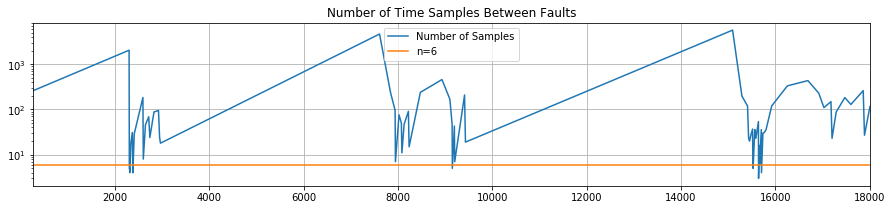

In [13]:
plt.figure(figsize=(15,3))
dfy['gaps'].plot(label='Number of Samples')
plt.plot([0, 18000], [6,6], label= 'n=6')
plt.title('Number of Time Samples Between Faults')
plt.yscale('log')
plt.grid()
plt.legend()
print(('Number of occurances of less than 6 time samples between faults: {}').format(sum(dfy['gaps']<=6)) )
plt.show()

The ramps in the above chart correspond to dropped data for x28 values not equal to 96.  The chart plot the original index on the x axis.

These 11 faults will be dropped formthisiteration.  Future attempts could include the 5 sample cases, but the missing sample will need to be replaced with zeros or an avergae of normal samples.

In [14]:
# Drop the faults and related samples where there are fewer than 6 samples between faults
Ind_6 = dfy[dfy['gaps']<7].index
for i in Ind_6:
    for j in range( dfy.loc[i][1] ):
        df['y'].loc[i-j] = 10

df = df[df['y']!=10]

print('Number of remaining faults is: ', df['y'].sum())
print('remaing shape of df is: ', df.shape)       

Number of remaining faults is:  61
remaing shape of df is:  (6522, 23)


In [15]:
# Reset the index
df=df.reset_index()

In [16]:
# Repeat to get a new dfy with remaining faults and gaps
dfy2 = pd.DataFrame(columns = ['y', 'gaps'])
dfy2['y'] = df['y'][df['y']==1]

Inds2 = dfy2.index
gaps=[]
for i in range(len(Inds2)):
    if i != 0:
        gaps.append(Inds2[i] - Inds2[i-1])
    else:
        gaps.append(Inds2[i])
dfy2['gaps'] = gaps
print('Mininmum samples between faults: ', min(dfy2['gaps']), 'Maximum samples between faults is: ', max(dfy2['gaps']) )

dfy2.head()

Mininmum samples between faults:  7 Maximum samples between faults is:  458


,y,gaps
259,1,259
536,1,277
554,1,18
585,1,31
593,1,8


Number of occurances of less than 6 time samples between faults: 0


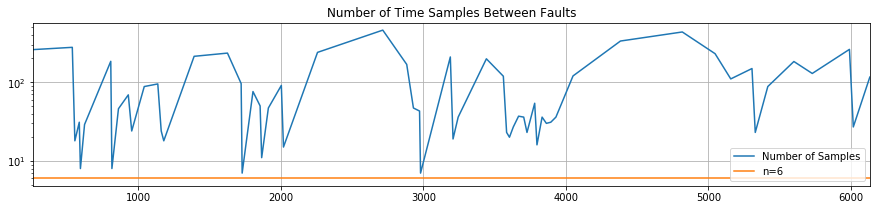

In [17]:
plt.figure(figsize=(15,3))
dfy2['gaps'].plot(label='Number of Samples')
plt.plot([0, 18000], [6,6], label= 'n=6')
plt.title('Number of Time Samples Between Faults')
plt.yscale('log')
plt.grid()
plt.legend()
print(('Number of occurances of less than 6 time samples between faults: {}').format( sum(dfy2['gaps']<=6)) )
plt.show()

### Now build a single and double derivative ('velocity' & 'acceleration') datasets, fixing the time delta at 2 (minutes) and ignore the time skipped after a sheet break.  These values at restart will be set to zero.

In [18]:
vel_cols = ['time', 'y']
acc_cols = ['time', 'y']
for item in df.columns[2:]:
    vel_cols.append(item + '_vel')
    acc_cols.append(item + '_acc')

In [19]:
df_vel = pd.DataFrame(columns = vel_cols)
df_vel['time'] = df['time']
df_vel['y'] = df['y']

df_vel.iloc[0,2:] = 0
df_vel.iloc[1:,2:] = (np.array( df.iloc[1:,2:]) - np.array( df.iloc[0:-1,2:]) )/2

# Show df_vel at the first fault, index 259
df_vel[257:262]

,time,y,y_vel,x2_vel,x3_vel,x9_vel,x10_vel,x11_vel,x12_vel,x13_vel,...,x41_vel,x42_vel,x44_vel,x45_vel,x46_vel,x47_vel,x52_vel,x53_vel,x54_vel,x59_vel
257,1999-05-01 08:34:00,0,0,0.0910975,0.0113925,0.005036,0,-0.140537,-0.042037,-1.87471,...,2.39941,0.004113,-3.64258,0.126879,-0.303735,-2.99448,0.0023195,0,-4.7e-05,0.38213
258,1999-05-01 08:36:00,0,0,0.003866,-0.0877905,0,0,0.047608,-0.077133,0.0585785,...,-0.512451,0.004113,-22.3955,0.525498,-0.263405,0.09155,0.0023195,0,-4.7e-05,0.482708
259,1999-05-01 08:38:00,1,0.5,-4.7321,-4.37831,0,0,-0.0698975,0.053729,1.6747,...,0.114075,0.004113,-11.0068,-0.612702,0.209844,-0.32959,0.002319,0,-4.75e-05,0.486832
260,1999-05-01 10:50:00,0,-0.5,4.67238,4.37902,0,0.029908,-0.549845,-0.845051,-32.2076,...,1.81305,0.271455,43.9053,-0.240597,-0.109865,-11.2415,-2.47522,-6.72949,-0.0721685,-0.0253905
261,1999-05-01 10:52:00,0,0,-0.541601,-0.580691,0,0,0.726049,0.066002,1.44137,...,-0.863831,0.004113,-16.1191,0.243199,0.229622,7.05057,0.007324,0.0286865,0.0004155,-0.194592


In [20]:
df_vel[257:262]

,time,y,y_vel,x2_vel,x3_vel,x9_vel,x10_vel,x11_vel,x12_vel,x13_vel,...,x41_vel,x42_vel,x44_vel,x45_vel,x46_vel,x47_vel,x52_vel,x53_vel,x54_vel,x59_vel
257,1999-05-01 08:34:00,0,0,0.0910975,0.0113925,0.005036,0,-0.140537,-0.042037,-1.87471,...,2.39941,0.004113,-3.64258,0.126879,-0.303735,-2.99448,0.0023195,0,-4.7e-05,0.38213
258,1999-05-01 08:36:00,0,0,0.003866,-0.0877905,0,0,0.047608,-0.077133,0.0585785,...,-0.512451,0.004113,-22.3955,0.525498,-0.263405,0.09155,0.0023195,0,-4.7e-05,0.482708
259,1999-05-01 08:38:00,1,0.5,-4.7321,-4.37831,0,0,-0.0698975,0.053729,1.6747,...,0.114075,0.004113,-11.0068,-0.612702,0.209844,-0.32959,0.002319,0,-4.75e-05,0.486832
260,1999-05-01 10:50:00,0,-0.5,4.67238,4.37902,0,0.029908,-0.549845,-0.845051,-32.2076,...,1.81305,0.271455,43.9053,-0.240597,-0.109865,-11.2415,-2.47522,-6.72949,-0.0721685,-0.0253905
261,1999-05-01 10:52:00,0,0,-0.541601,-0.580691,0,0,0.726049,0.066002,1.44137,...,-0.863831,0.004113,-16.1191,0.243199,0.229622,7.05057,0.007324,0.0286865,0.0004155,-0.194592


#### As shown above in time steps 259 to 260, there is a re-start of the process and the derivative ('velocity') is not representative.
#### Therefore, reset values after each sheet break on df_vel to zero.   This will also eliminate large swings in the double derivative.  
#### Then repeat with the 'acceleration' data.

In [21]:
Indx = 0

for row in range(len(dfy2)):
    gap = dfy2.iloc[row,1]
    Indx = Indx + gap 
    df_vel.iloc[Indx+1, 2:] = 0

df_vel[257:262]

,time,y,y_vel,x2_vel,x3_vel,x9_vel,x10_vel,x11_vel,x12_vel,x13_vel,...,x41_vel,x42_vel,x44_vel,x45_vel,x46_vel,x47_vel,x52_vel,x53_vel,x54_vel,x59_vel
257,1999-05-01 08:34:00,0,0,0.0910975,0.0113925,0.005036,0,-0.140537,-0.042037,-1.87471,...,2.39941,0.004113,-3.64258,0.126879,-0.303735,-2.99448,0.0023195,0,-4.7e-05,0.38213
258,1999-05-01 08:36:00,0,0,0.003866,-0.0877905,0,0,0.047608,-0.077133,0.0585785,...,-0.512451,0.004113,-22.3955,0.525498,-0.263405,0.09155,0.0023195,0,-4.7e-05,0.482708
259,1999-05-01 08:38:00,1,0.5,-4.7321,-4.37831,0,0,-0.0698975,0.053729,1.6747,...,0.114075,0.004113,-11.0068,-0.612702,0.209844,-0.32959,0.002319,0,-4.75e-05,0.486832
260,1999-05-01 10:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,1999-05-01 10:52:00,0,0,-0.541601,-0.580691,0,0,0.726049,0.066002,1.44137,...,-0.863831,0.004113,-16.1191,0.243199,0.229622,7.05057,0.007324,0.0286865,0.0004155,-0.194592


In [22]:
df_acc = pd.DataFrame(columns = acc_cols)
df_acc['time'] = df['time']
df_acc['y'] = df['y']

df_acc.iloc[0,2:] = 0
df_acc.iloc[1:,2:] = (np.array( df_vel.iloc[1:,2:]) - np.array( df_vel.iloc[0:-1,2:]) )/2

df_acc[257:262]

,time,y,y_acc,x2_acc,x3_acc,x9_acc,x10_acc,x11_acc,x12_acc,x13_acc,...,x41_acc,x42_acc,x44_acc,x45_acc,x46_acc,x47_acc,x52_acc,x53_acc,x54_acc,x59_acc
257,1999-05-01 08:34:00,0,0,0.0937172,-0.003459,0.002518,0,-0.115919,-0.0170607,-2.0821,...,2.40973,0,-0.760742,0.19537,-0.383251,-4.07716,2.5e-07,0,0,0.0863498
258,1999-05-01 08:36:00,0,0,-0.0436157,-0.0495915,-0.002518,0,0.0940725,-0.017548,0.966644,...,-1.45593,0,-9.37646,0.19931,0.0201652,1.54301,-4.44089e-16,0,0,0.050289
259,1999-05-01 08:38:00,1,0.25,-2.36798,-2.14526,0,0,-0.0587527,0.065431,0.80806,...,0.313263,0,5.69434,-0.5691,0.236625,-0.21057,-2.5e-07,0,-2.5e-07,0.00206175
260,1999-05-01 10:50:00,0,-0.25,2.36605,2.18916,0,0,0.0349488,-0.0268645,-0.837349,...,-0.0570373,-0.0020565,5.50342,0.306351,-0.104922,0.164795,-0.0011595,0,2.375e-05,-0.243416
261,1999-05-01 10:52:00,0,0,-0.270801,-0.290345,0,0,0.363025,0.033001,0.720684,...,-0.431916,0.0020565,-8.05957,0.121599,0.114811,3.52528,0.003662,0.0143433,0.00020775,-0.0972958


In [23]:
Indx = 0

for row in range(len(dfy2)):
    gap = dfy2.iloc[row,1]
    Indx = Indx + gap 
    df_acc.iloc[Indx+1, 2:] = 0

df_acc[257:262]

,time,y,y_acc,x2_acc,x3_acc,x9_acc,x10_acc,x11_acc,x12_acc,x13_acc,...,x41_acc,x42_acc,x44_acc,x45_acc,x46_acc,x47_acc,x52_acc,x53_acc,x54_acc,x59_acc
257,1999-05-01 08:34:00,0,0,0.0937172,-0.003459,0.002518,0,-0.115919,-0.0170607,-2.0821,...,2.40973,0,-0.760742,0.19537,-0.383251,-4.07716,2.5e-07,0,0,0.0863498
258,1999-05-01 08:36:00,0,0,-0.0436157,-0.0495915,-0.002518,0,0.0940725,-0.017548,0.966644,...,-1.45593,0,-9.37646,0.19931,0.0201652,1.54301,-4.44089e-16,0,0,0.050289
259,1999-05-01 08:38:00,1,0.25,-2.36798,-2.14526,0,0,-0.0587527,0.065431,0.80806,...,0.313263,0,5.69434,-0.5691,0.236625,-0.21057,-2.5e-07,0,-2.5e-07,0.00206175
260,1999-05-01 10:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,1999-05-01 10:52:00,0,0,-0.270801,-0.290345,0,0,0.363025,0.033001,0.720684,...,-0.431916,0.0020565,-8.05957,0.121599,0.114811,3.52528,0.003662,0.0143433,0.00020775,-0.0972958


In [24]:
df_acc.tail()

,time,y,y_acc,x2_acc,x3_acc,x9_acc,x10_acc,x11_acc,x12_acc,x13_acc,...,x41_acc,x42_acc,x44_acc,x45_acc,x46_acc,x47_acc,x52_acc,x53_acc,x54_acc,x59_acc
6517,1999-05-28 23:58:00,0,0,-0.00770225,0.0195992,0,0,0.0209402,0.0398513,-1.38977,...,2.80719,0,18.1337,-0.496016,0.333078,0.0720978,0,0,1.11022e-16,-0.22411
6518,1999-05-29 00:00:00,0,0,-0.0511315,0.00378925,0,0,0.0154953,-0.0376838,0.882492,...,-3.71661,-2.5e-07,2.57325,0.336838,-0.163538,1.767,0,0,0,-0.13639
6519,1999-05-29 00:02:00,0,0,-0.007404,-0.095707,0,0,-0.0115078,0.035827,1.57059,...,-3.04925e-05,2.5e-07,0.185575,-0.0918552,0.0344188,-1.51482,0,0,0,0.291502
6520,1999-05-29 00:04:00,0,0,0.0380543,0.0700043,0,0,0.00627825,-0.00495976,-2.95881,...,0.165711,0,-0.000525,-0.0777415,0.167253,-0.687546,0,0,2.5e-07,0.0810525
6521,1999-05-29 00:06:00,0,0,0.0485175,0.038368,0.00251775,0,-0.0239777,-0.0155387,-0.494038,...,0.880768,0,0.0005,0.130964,-0.109592,-0.683945,0,0,-2.5e-07,-0.435448


### First determine the number of images.  Once the break condition sample is first recorded on an image, the break has occured and the next image will start with the following 5 samples.  Normal condition samples will appear on 5 images, whereas the break sample only appears on 1 image.

In [25]:
# image count is number of time periods less 5 if there are no break condition.
# take away the number of time periods for all situations where the gap between breaks is <= 6 
#    - retain this for when samples are not screened out
# take away 6 time periods, and therefore images when the image resets once a break reaches the image.

image_count = len(df) - 5 - sum(dfy2['gaps'][dfy2['gaps']<=6]) - 6*(sum(df['y']) - len(dfy2[dfy2['gaps']<=6]) )
image_count, (sum(df['y']) - len(dfy2[dfy2['gaps']<=5]) )

(6151, 61)

In [26]:
df_s = df.drop(['time', 'y'], axis = 1)
df_vel_s = df_vel.drop(['time', 'y'], axis = 1)
df_acc_s = df_acc.drop(['time', 'y'], axis = 1)

y_true = df['y'].values
print('Check, sum of y_true:', sum(y_true) )

Check, sum of y_true: 61


In [27]:
scaler = MinMaxScaler(feature_range=(0,1) )

df_s=scaler.fit_transform(df_s)
df_vel_s=scaler.fit_transform(df_vel_s)
df_acc_s=scaler.fit_transform(df_acc_s)

In [28]:
Ws, Wv, Wa = df_s.shape[1], df_vel_s.shape[1], df_acc_s.shape[1]
Ws, Wv, Wa

(22, 22, 22)

In [29]:
df_s.shape, df_vel_s.shape, df_acc_s.shape

((6522, 22), (6522, 22), (6522, 22))

### Build an image array with 6 measurement, 'velocity', & 'acceleration' time slices on each 12 minute time range image.

In [30]:
images = np.zeros((image_count,18,Ws))
Y = np.zeros((image_count)).astype(int)
lbl = np.zeros((image_count)).astype(int)

In [31]:
lbl.shape

(6151,)

In [32]:
# Build Image set with Y labels as 1-5 for images 5 time periods in advance of actual fault.
# Build the image in one slice - 6 rows, of each position, velocity, & acceleration at a time, resetting after a break.

print('image#, first row, last row,         y')
i = 0
pos_target_num = 0

for c in range(image_count):
       
    images[c,0:6,:] = df_s[i:i+6,:]         # Load 6 rows of position values
    
    images[c,6:12,0:] = df_vel_s[i:i+6,:]   # Load 6 rows of 'velocity / first derivative' values
    
    images[c,12:18,0:] = df_acc_s[i:i+6,:]   # Load 6 rows of 'acceleration / second derivative' values
    
    lbl[c] = y_true[i+5]                    # label images with faults as 1
    Y[c] = 1*(y_true[i+10]==1) + 2*(y_true[i+9]==1) + 3*(y_true[i+8]==1) + 4*(y_true[i+7]==1) + 5*(y_true[i+6]==1) + 6*(y_true[i+5]==1)

    if Y[c] == 6: 
        print(('{:^10}{:^14}{:^10}{:^10}').format(c, i, i+5, y_true[i+5])) 
        i = i + 6
    else:
        i = i + 1

print(('{:^10}{:^14}{:^10}{:^10}').format(c, i-1, i+5-1, y_true[i+5-1]))   

image#, first row, last row,         y
   254         254         259        1     
   526         531         536        1     
   539         549         554        1     
   565         580         585        1     
   568         588         593        1     
   592         617         622        1     
   771         801         806        1     
   774         809         814        1     
   815         855         860        1     
   879         924         929        1     
   898         948         953        1     
   981         1036        1041       1     
   1071        1131        1136       1     
   1090        1155        1160       1     
   1103        1173        1178       1     
   1311        1386        1391       1     
   1540        1620        1625       1     
   1631        1716        1721       1     
   1633        1723        1728       1     
   1704        1799        1804       1     
   1749        1849        1854       1     
   1755        1

In [33]:
c, i-1, lbl.sum()

(6150, 6455, 61)

In [34]:
# Check the number of occurances of labels 0 - 6
(Y==6).sum(), (Y==5).sum(), (Y==4).sum(), (Y==3).sum(), (Y==2).sum(), (Y==1).sum(), (Y==0).sum(), len(Y)

(61, 61, 59, 57, 57, 57, 5799, 6151)

Y classes of 1,2, 3, & 4 are fewer than 5 & 6 because of breaks occuring less than 11 samples apart.

### Plot 12 images leading up to a fault and the first image after a reset.

Image and prediction for Image 244 through 255


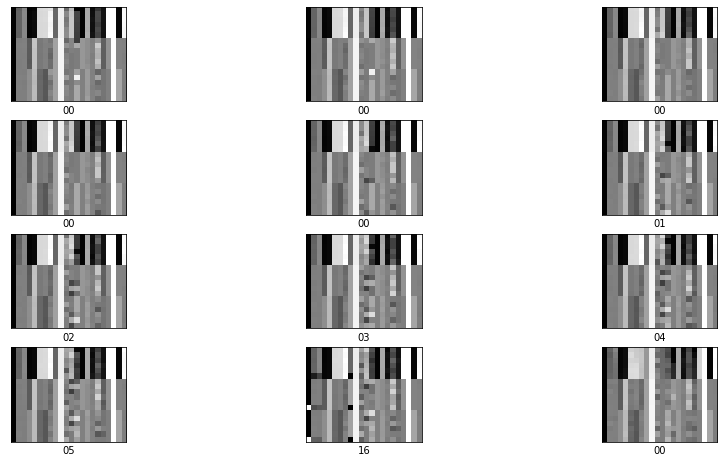

In [35]:
# Compare results in a display of images
print('Image and prediction for Image 244 through 255')
plt.figure(figsize=(15,8))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i+244], cmap='gray')
    plt.xlabel(str(lbl[i+244]) + str(Y[i+244])) #(class_labels[y_pred[i+j]]+' '+str(y_pred[i+j]==y_test[i+j]))
plt.show()

### Plot the increment of the 12 images, the difference of each image vs. theprior image.  This makes it easier to see changes approaching a break.

Image and prediction for Image 243 through 254, Left label is original 0,1; right label is 1-5 warning & 6 as break


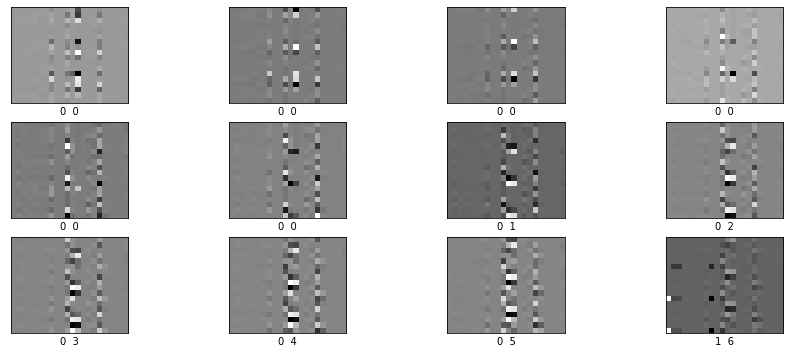

In [36]:
# Compare the difference of subsequent images from the first image
print('Image and prediction for Image 243 through 254, Left label is original 0,1; right label is 1-5 warning & 6 as break')
plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i+243]-images[i+242], cmap='gray')
    plt.xlabel(str(lbl[i+243]) + '  ' +  str(Y[i+243]))
plt.show()

#### Below is an example of two breaks almost back to back at image 2822.  There aren' enough intermediate samples to buils anough images for the warning label to go to zero.

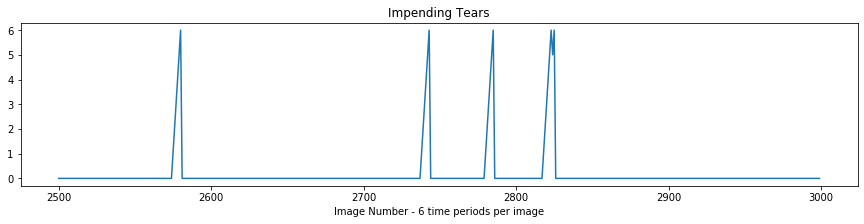

In [37]:
plt.figure(figsize=(15,3))
plt.plot(range(2500,3000),Y[2500:3000])
plt.title("Impending Tears")
plt.xlabel('Image Number - 6 time periods per image')
plt.show()

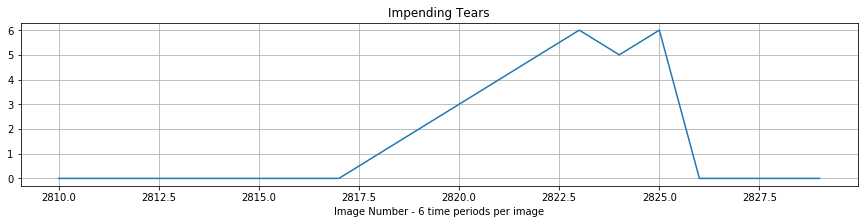

In [38]:
plt.figure(figsize=(15,3))
plt.plot(range(2810,2830),Y[2810:2830])
plt.title("Impending Tears")
plt.xlabel('Image Number - 6 time periods per image')
plt.grid()
plt.show()

### The forth spike in the upper chart is shown in detail above and  shows a case where two faults occur back to back.  The trailing fault is 7 samples after the first.  Image 2823 has the last time sample labelled 6.  Image 2824 has the last time sample with label 5 then image 2825 increments one time sample and again has the last time sample labelled as 6.   Image 2826 has all normal time samples labelled as 0.
### The no. 6 labels correspond to a 1 label in the original data and the preceeding 5 samples are labelled 0 in the original data.  These 5 are transformed from 0's to 1 to 5 and the fault from 1 to 6,

In [39]:
images.size, images.itemsize, images.shape

(2435796, 8, (6151, 18, 22))

In [40]:
# Build train and test set from the undersampled image dataset
x_train, x_test, y_train, y_test = train_test_split(images, Y, stratify = Y, test_size=0.35, random_state = 0)

In [41]:
x_train.shape, x_test.shape, len(y_train), len(y_test)

((3998, 18, 22), (2153, 18, 22), 3998, 2153)

In [42]:
tr_s, te_s = x_train.shape[0], x_test.shape[0]

### Save a viewable copy of x_train & x_test to display results


In [43]:
# Save a viewable copy of x_train & x_test to display results
x_te = x_test
x_tr = x_train
x_tr.shape, x_te.shape

((3998, 18, 22), (2153, 18, 22))

In [44]:
x_train = x_train.reshape(tr_s,18,22,1)
x_test = x_test.reshape(te_s,18,22,1)

#### Adjust the CNN input to -0.5 to +0.5

In [45]:
x_train = x_train - 0.5
x_test = x_test - 0.5

In [46]:
# Create an entire dataset to predict the trained model on, where the faults are in order vs. the train / test sets.
full = (images-0.5).reshape(6151, 18, 22, 1)

### Build a custom predictor to account for dataset imbalance, and a plotting function

In [47]:
def Adjusted_Pred(y_prob, threshold):
    A_prob = np.zeros(y_prob.shape).astype(float)
    A_prob[:,0:7] = y_prob
    for i in range(1,7):
        A_prob[:,i] = A_prob[:,i]*(A_prob[:,i]>=(1-threshold)/6)  # Sets prob to 0 if it is less than average frequency
    for j in range ( len(y_prob) ):
        if sum(A_prob[j,1:7])>0:
            A_prob[j,0] = A_prob[j,0]*(A_prob[j,0]>=threshold)  # normal probability only if probability exceeds the ratio of normals in the set  
    A_pred = A_prob[:,0]
    A_pred = A_prob[:,0:7].argmax(axis=1) 
    return A_pred

In [48]:
def Three_Track_Plot(actual, pred, prob, a, b, title1, fig_height=6):
    Rge=range(a,b)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,fig_height))
    ax1.plot(Rge, pred[a:b], label = "Adjusted ArgMax Prediction", ls = '--', lw=0.5, marker = 'o', markersize = 2)
    ax2.plot(Rge, actual[a:b], label ="Actual Label", c ='orange', ls = '--', lw = 1)
    ax3.plot(Rge, prob[a:b,6], label ="Fault", c = 'g')
    ax3.plot(Rge, prob[a:b,5], label ="100%")
    ax3.plot(Rge, prob[a:b,4], label ="80%")
    ax3.plot(Rge, prob[a:b,3], label ="60%")
    ax3.plot(Rge, prob[a:b,2], label ="40%")
    ax3.plot(Rge, prob[a:b,1], label ="20%")

    ax1.set_title(('{}{}{}').format('Predicted Impending Fault on ', title1, '\n Adjusted ArgMax Prediction'))
    ax2.set_title('Actual Label, 6 = Fault, 1-5 = Warning')
    ax3.set_title('Probability of Class')
    plt.xlabel('Image number')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Build a CNN model and fit.

In [49]:
# Build Model
#sgd = optimizers.SGD(lr=0.005, decay=5e-4, momentum=0.5, nesterov=False)

model = Sequential()
model.add(Conv2D(4, (3,3), input_shape = (18, Ws, 1), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(4, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))

model.add(Dropout(0.15))
model.add(Dense(units = 64, activation = 'relu'))

model.add(Dense(units = 7, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [50]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=50, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

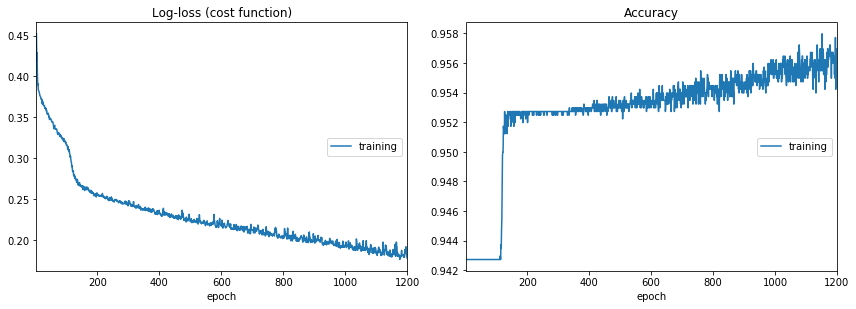

Log-loss (cost function):
training   (min:    0.176, max:    1.591, cur:    0.178)

Accuracy:
training   (min:    0.935, max:    0.958, cur:    0.956)


In [51]:
# Fit the model & train for 100 epochs initially, livelossplot in callbacks, validation split 
# and higher batch size to improve speed
model.fit(x_train, y_train, validation_split = 0.0, callbacks = [live_plot, early_stop], initial_epoch = 0, epochs = 1200, batch_size = 512)

In [52]:
#  Set threshold for the normal class
TH_N = 1-6*61/6151   # 1 minus the average frequency for labels 1 through 6
TH_N

0.9404974800845392

### x_test performance

In [53]:
y_prob = model.predict_proba(x_test)
a_pred = Adjusted_Pred(y_prob, TH_N)

In [54]:
x_test_cm = confusion_matrix(y_test,a_pred)
print('x_test confusion matrix')
x_test_cm

x_test confusion matrix


array([[1807,   70,   45,   28,   26,   54,    0],
       [  10,    0,    3,    3,    2,    2,    0],
       [   7,    5,    1,    3,    2,    2,    0],
       [  13,    1,    2,    0,    1,    3,    0],
       [   6,    5,    2,    2,    2,    4,    0],
       [  15,    1,    2,    1,    1,    1,    0],
       [   0,    0,    0,    0,    0,    0,   21]], dtype=int64)

Faults are classified properly, warning classes (1-5) are classified about half the time as normal and often as other warning classes.  8% of of normals are misclassified as warning classes.

In [55]:
print('x_test classification report \n\n',classification_report(y_test,a_pred))

x_test classification report 

               precision    recall  f1-score   support

           0       0.97      0.89      0.93      2030
           1       0.00      0.00      0.00        20
           2       0.02      0.05      0.03        20
           3       0.00      0.00      0.00        20
           4       0.06      0.10      0.07        21
           5       0.02      0.05      0.02        21
           6       1.00      1.00      1.00        21

    accuracy                           0.85      2153
   macro avg       0.29      0.30      0.29      2153
weighted avg       0.93      0.85      0.89      2153



In [56]:
# Compare results in table of predictions from index 16 to 30
class_labels = ['normal','20%','40%','60%','80%','100%', 'FAULT']
dash='='*65
print(dash,'\n','{:<10}{:<14}{:<14}{:12}{:18}'.format('x_test','prediction','actual','Correct','% Prob of Prediction'))
print(dash)
j = 2090 #offset from 0 to wanted begining index for sample
for i in range(15):
    y_p = class_labels[a_pred[i+j]]
    y_a = class_labels[y_test[i+j]]
    print(' {:<10}{:<14}{:<14}{:<12}{:6}'.format(i+j,y_p,y_a,str(y_p == y_a), int(100*y_prob[i+j][a_pred[i+j].astype('int')])))

 x_test    prediction    actual        Correct     % Prob of Prediction
 2090      normal        normal        True            95
 2091      normal        normal        True            99
 2092      40%           normal        False           19
 2093      normal        normal        True            95
 2094      normal        normal        True            99
 2095      FAULT         FAULT         True            99
 2096      20%           80%           False            6
 2097      normal        normal        True            98
 2098      normal        normal        True            99
 2099      normal        normal        True            99
 2100      normal        normal        True            99
 2101      normal        normal        True            99
 2102      normal        normal        True            97
 2103      normal        normal        True            97
 2104      100%          normal        False            6


Here two normal samples are classified as a warning class, one warning class and one fault are predicted.

x_test image with prediction and y_test class


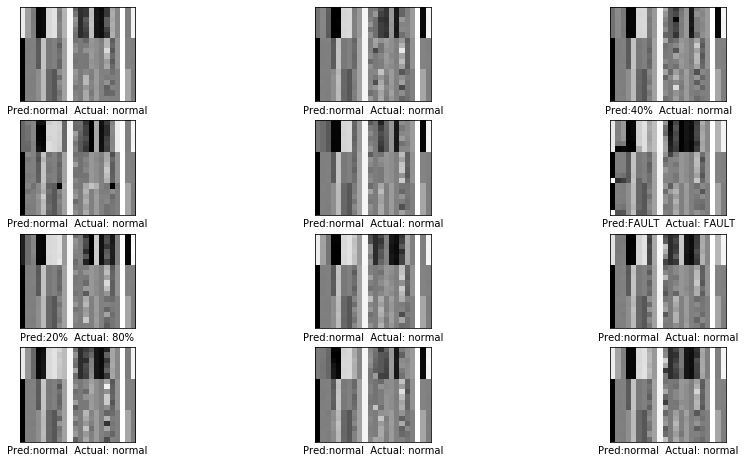

In [57]:
###### Compare results in a display of 15 images from index 16 to 30
j=2090 #(offset to view subset)

print('x_test image with prediction and y_test class')
plt.figure(figsize=(15,8))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_te[i+j], cmap='gray')
    plt.xlabel('Pred:'+ class_labels[a_pred[i+j]]+'  Actual: '+ class_labels[y_test[i+j]])
plt.show()

#### x_test prediction, label and probability by class. 

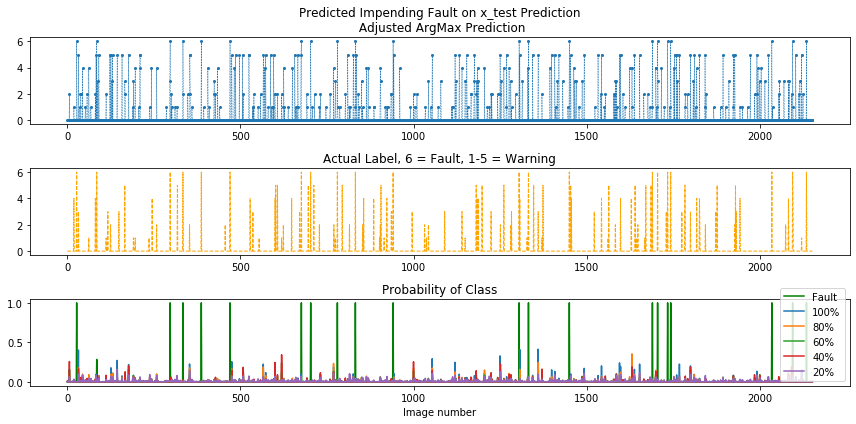

In [58]:
Three_Track_Plot(y_test, a_pred, y_prob, 0, len(y_test), 'x_test Prediction')

Actual faults (paper breaks) were predicted accurately in the test set, however, there are many false warnings and the warnings are not consistently predicted.  It is difficult to tell if the warnings appear ahead of a fault since the test set is shuffled.

#### Subset of x_test prediction, label and probability by class. 

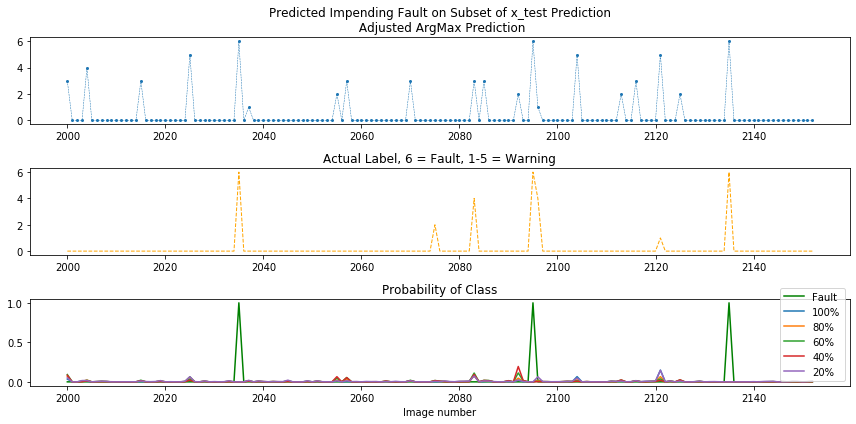

In [59]:
Three_Track_Plot(y_test, a_pred, y_prob, 2000, len(y_test), 'Subset of x_test Prediction')

### x_train fitting performance

In [60]:
y_prob_train = model.predict_proba(x_train)
a_pred_train = Adjusted_Pred(y_prob_train, TH_N)

In [61]:
x_train_cm = confusion_matrix(y_train,a_pred_train)
print('x_train confusion matrix')
x_train_cm

x_train confusion matrix


array([[3368,  138,   61,  102,   41,   59,    0],
       [  10,   11,    1,    3,    5,    7,    0],
       [   5,    2,   21,    1,    1,    7,    0],
       [   4,    4,   13,    4,    6,    6,    0],
       [   5,    4,    5,    3,   11,   10,    0],
       [   3,    2,    4,    1,    3,   27,    0],
       [   0,    0,    0,    0,    0,    0,   40]], dtype=int64)

The training fit well to faults and identified most of the warning classes as a grouping, but not specifically by the warning class label.  The model isn't general enough to be as consistent in the test set prediction.  6% of normal samples are predicted as warning classes 1 to 5.  Consider grouping the warning classes as a sinlge class.

In [62]:
print('x_train classification report \n\n',classification_report(y_train,a_pred_train))

x_train classification report 

               precision    recall  f1-score   support

           0       0.99      0.89      0.94      3769
           1       0.07      0.30      0.11        37
           2       0.20      0.57      0.30        37
           3       0.04      0.11      0.05        37
           4       0.16      0.29      0.21        38
           5       0.23      0.68      0.35        40
           6       1.00      1.00      1.00        40

    accuracy                           0.87      3998
   macro avg       0.38      0.55      0.42      3998
weighted avg       0.95      0.87      0.91      3998



#### x_train prediction, label and probability by class. 

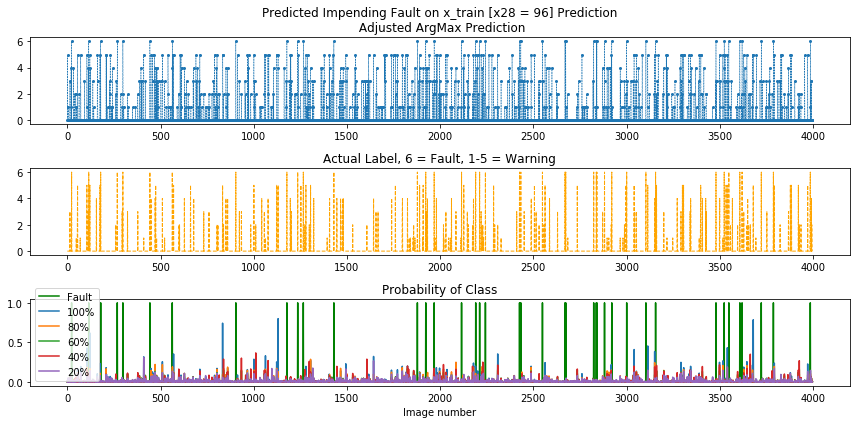

In [63]:
Three_Track_Plot(y_train, a_pred_train, y_prob_train, 0, len(y_train), 'x_train [x28 = 96] Prediction')

#### Subset of x_train prediction, label and probability by class. 

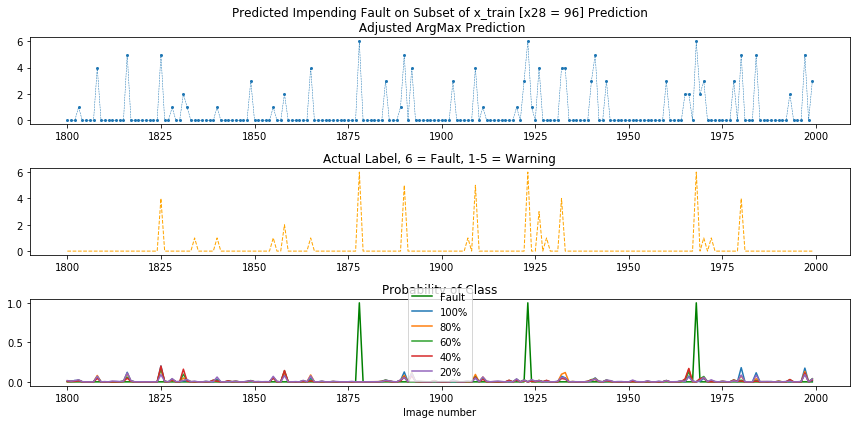

In [64]:
Three_Track_Plot(y_train, a_pred_train, y_prob_train, 1800, 2000, 'Subset of x_train [x28 = 96] Prediction')

#### Look at how the model behaves viewing the dataset in order, rather than random class labels

In [65]:
y_prob_full = model.predict_proba(full)
a_pred_full = Adjusted_Pred(y_prob_full, TH_N)

#### The full dataset: x28 = 96

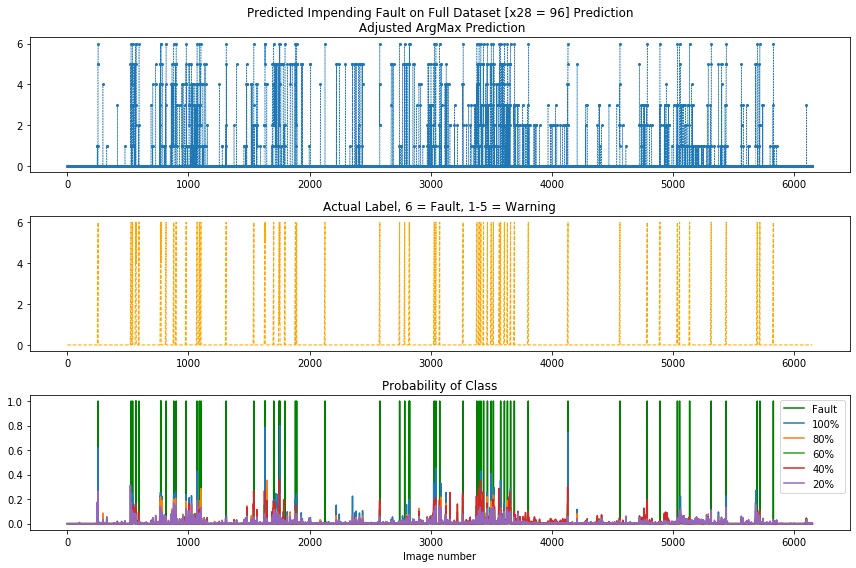

In [66]:
Three_Track_Plot(Y, a_pred_full, y_prob_full, 0, len(Y), 'Full Dataset [x28 = 96] Prediction', fig_height=8)

#### Subset of the full dataset in order.

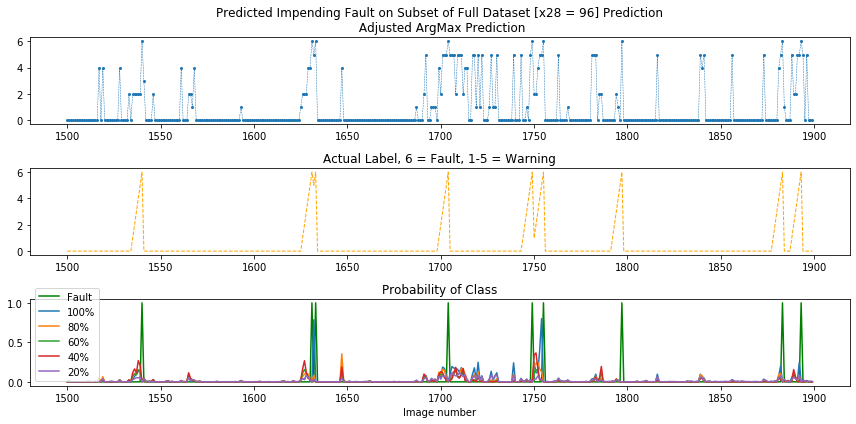

In [67]:
Three_Track_Plot(Y, a_pred_full, y_prob_full, 1500, 1900, 'Subset of Full Dataset [x28 = 96] Prediction')

This section of the data does have warning class predictions ahead of the fault classes. 

In [68]:
# Save model
model.save("PaperMachine_SheetBreak_DVA_model_x28_96_1.h5")